# <center> Fast Food Marketing Campaign A\B Test Analysis <center>

## <center>Introduction</center>

In this analysis, we aim to evaluate the effectiveness of three different marketing campaigns introduced by a fast-food chain to promote a new menu item. The new item was introduced at various locations in several randomly selected markets, each employing a different promotional strategy. The sales data for the new item were recorded over the first four weeks.

### <center> Goal <center>
The primary goal of this A/B test is to determine which of the three marketing campaigns has the greatest positive impact on sales of the new menu item. By comparing the sales performance across different promotions, we aim to identify the most effective strategy for increasing sales.

### <center>Target Metric<center>
To measure the success of each marketing campaign, we will focus on the `SalesInThousands` metric. This metric represents the weekly sales of the new item in thousands of dollars for each store location, promotion, and week. By analyzing this metric, we can assess how each promotion influences sales over time and determine which campaign yields the highest sales performance.

### <center>Dataset Description<center>
The dataset contains the following columns:
- `MarketID`: Unique identifier for each market.
- `MarketSize`: Size of the market area based on sales.
- `LocationID`: Unique identifier for each store location.
- `AgeOfStore`: Age of the store in years.
- `Promotion`: One of the three promotions being tested.
- `week`: The specific week during which the promotions were run (from 1 to 4).
- `SalesInThousands`: Sales amount in thousands of dollars for a specific `LocationID`, `Promotion`, and `week`.

With this analysis, we will aggregate and prepare the data, conduct statistical tests to compare the promotions, estimate the treatment effects, and ultimately recommend the most effective marketing strategy.

## <center> Imports and requirements <center>

In [1]:
%%capture
%pip install -r requirements.txt

The warnings library is used to hide unnecessary messages

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import helper_functions as hp
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import statsmodels.stats.multitest as multitest


## <center> Loading and cleaning dataset <center>

In [4]:
marketing_data= pd.read_csv('datasets/WA_Marketing-Campaign.csv')
marketing_data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


Here we apply one of the helper functions to lowercase text and remove whitespaces. This is done so that the duplication check is more accurate.

In [5]:
marketing_data['MarketSize'] = marketing_data['MarketSize'].apply(hp.clean_string)

In [6]:
marketing_data.isnull().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [7]:
marketing_data.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

In [8]:
marketing_data.duplicated().sum()

0

Using a boxplot, let's check for outliers by promotion.

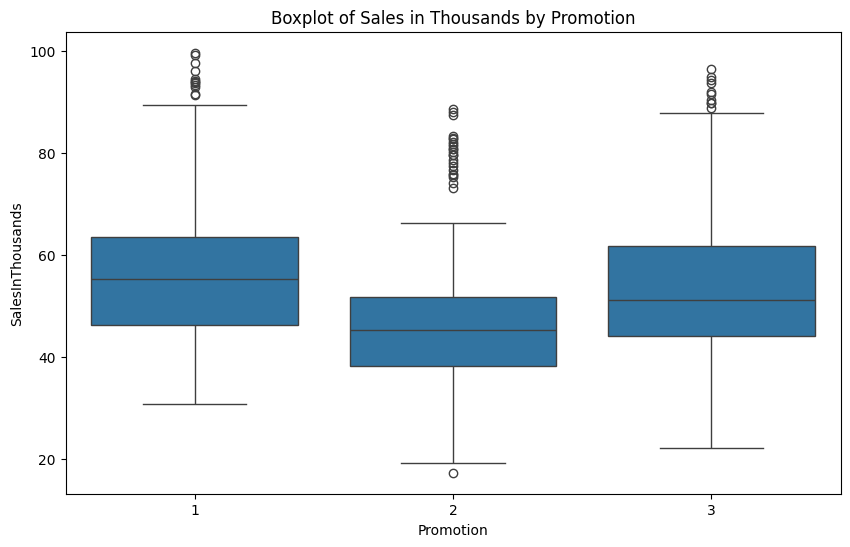

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesInThousands', data=marketing_data)
plt.title('Boxplot of Sales in Thousands by Promotion')
plt.show()

As we can see, there are some outliers, so we filter them out and check what they consist of.

In [10]:
Q1 = marketing_data['SalesInThousands'].quantile(0.25)
Q3 = marketing_data['SalesInThousands'].quantile(0.75)
IQR = Q3 - Q1

outliers = marketing_data[(marketing_data['SalesInThousands'] < (Q1 - 1.5 * IQR)) | 
                          (marketing_data['SalesInThousands'] > (Q3 + 1.5 * IQR))]

outliers_df = outliers
outliers_df.head()


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
80,3,large,202,8,1,1,88.73
83,3,large,202,8,1,4,94.17
84,3,large,203,12,3,1,89.70
88,3,large,204,1,2,1,87.43
90,3,large,204,1,2,3,88.12


In [11]:
market_id_distribution = outliers_df['MarketID'].value_counts()
print("MarketID Distribution in Outliers:")
market_id_distribution

MarketID Distribution in Outliers:


MarketID
3    33
Name: count, dtype: int64

Let's check if there is a specific location that causes this.

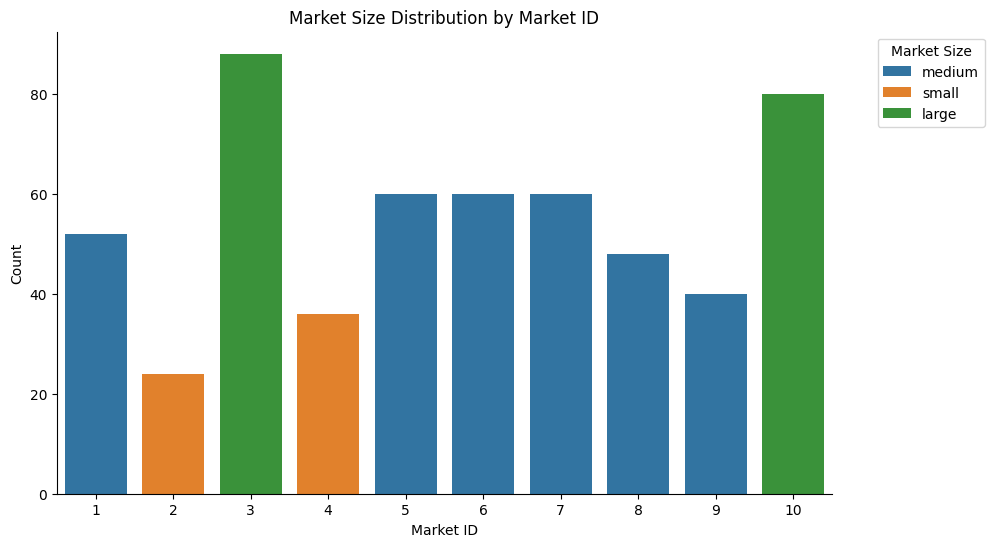

In [12]:

plt.figure(figsize=(10, 6))
sns.countplot(x='MarketID', hue='MarketSize', data=marketing_data)
plt.title('Market Size Distribution by Market ID')
plt.xlabel('Market ID')
plt.ylabel('Count')
plt.legend(title='Market Size', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()

In [13]:
market_3_data = marketing_data[marketing_data['MarketID'] == 3]
location_ids_market_3 = market_3_data['LocationID'].unique()
print("LocationIDs belonging to MarketID 3:")
location_ids_market_3

LocationIDs belonging to MarketID 3:


array([201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222], dtype=int64)

In [14]:
location_id_distribution = outliers_df['LocationID'].value_counts()
location_id_distribution_filtered = location_id_distribution[location_id_distribution > 0]
location_id_distribution_filtered.size

17

After manually checking the outliers, we can see that all of them belong to MarketID = 3, which is a large market. Additionally, considering the fact that 17 out of 22 locations are flagged as outliers, and not just 1 or 2, we can assume that this market overall is bringing in higher sales. Considering these facts, larger sales numbers may be expected there.

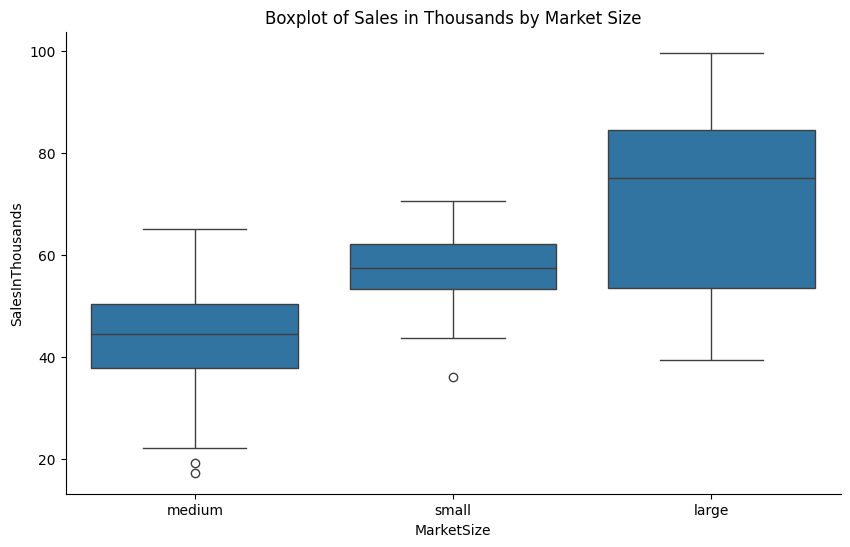

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='MarketSize', y='SalesInThousands', data=marketing_data)
plt.title('Boxplot of Sales in Thousands by Market Size')
sns.despine()
plt.show()

When we check if overall sales counts are unusual for the market size, we can see that there are no abnormalities. For this reason, outliers will be kept in the dataset.

## <center> EDA <center>

In [16]:
marketing_data.describe(include='all')

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548,548.000000,548.000000,548.000000,548.000000,548.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,medium,NaN,NaN,NaN,NaN,NaN
freq,NaN,320,NaN,NaN,NaN,NaN,NaN
mean,5.715328,NaN,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,NaN,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,NaN,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,NaN,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,NaN,708.000000,12.000000,3.000000,3.250000,60.477500


Let's check the sales distributions from different aspects.

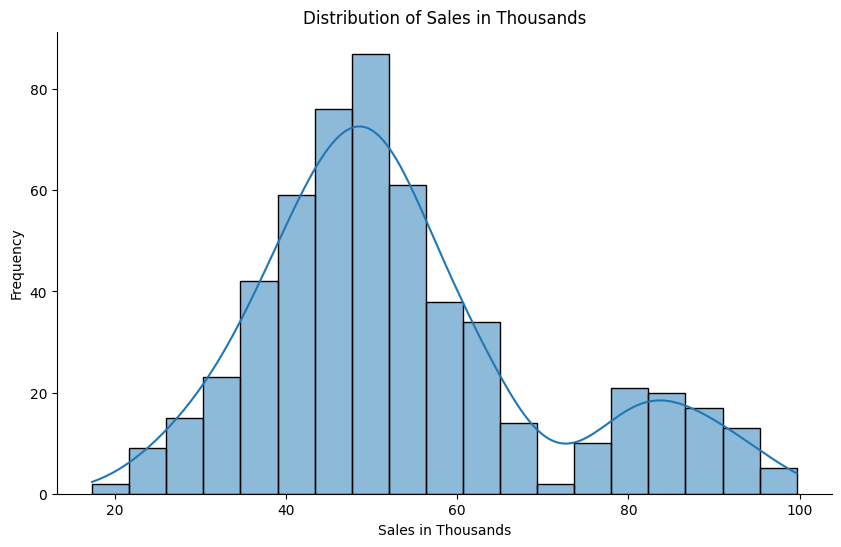

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(marketing_data['SalesInThousands'], kde=True)
plt.title('Distribution of Sales in Thousands')
plt.xlabel('Sales in Thousands')
plt.ylabel('Frequency')
sns.despine()
plt.show()


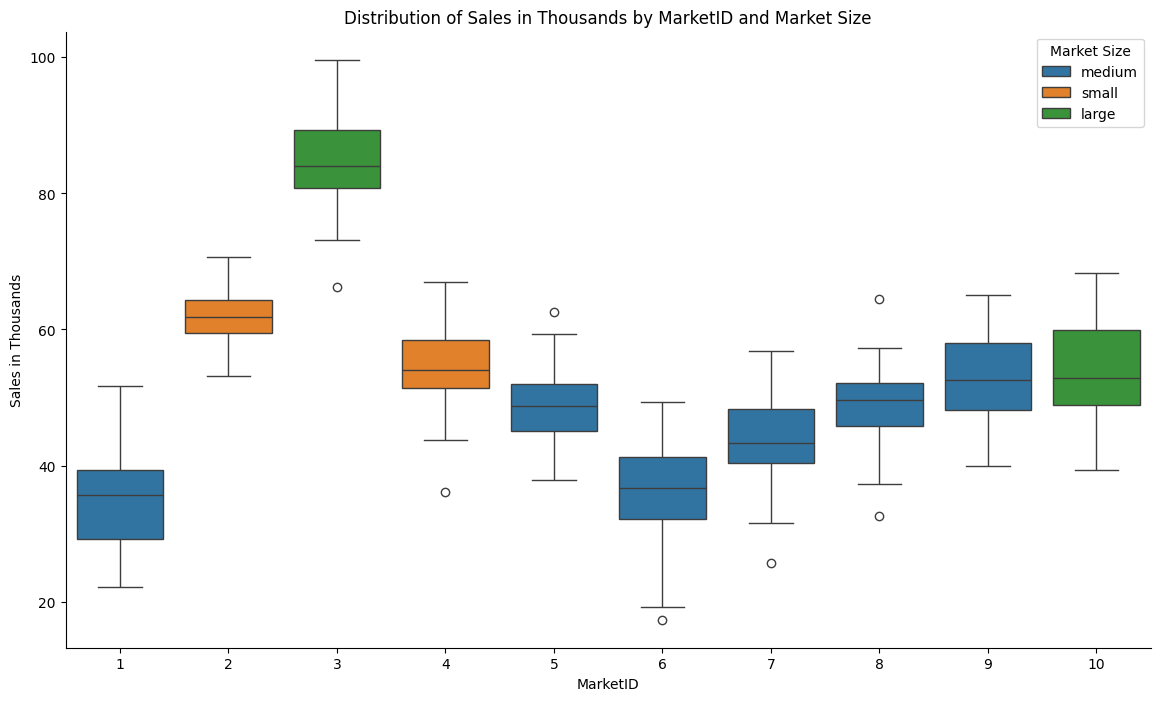

In [18]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='MarketID', y='SalesInThousands', hue='MarketSize', data=marketing_data)
plt.title('Distribution of Sales in Thousands by MarketID and Market Size')
plt.xlabel('MarketID')
plt.ylabel('Sales in Thousands')
plt.legend(title='Market Size')
sns.despine()
plt.show()

It's quite interesting to see that small markets are outperforming medium ones and even some of the large ones.

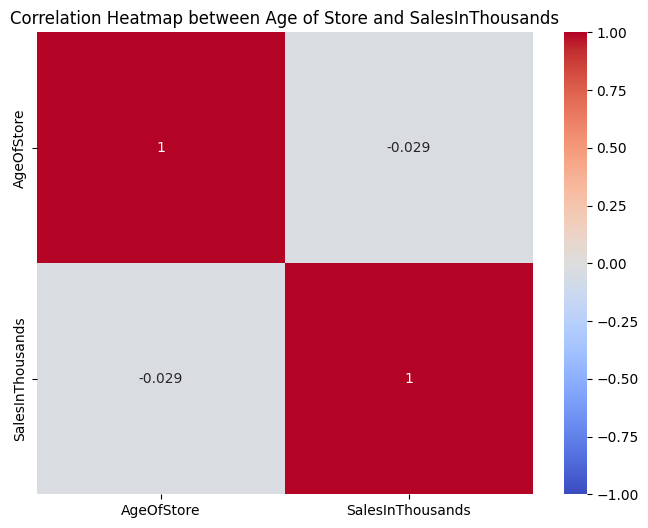

In [19]:
correlation_matrix = marketing_data[['AgeOfStore', 'SalesInThousands']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Age of Store and SalesInThousands')
plt.show()

It doesn't look like the age of the store has any influence on sales numbers.

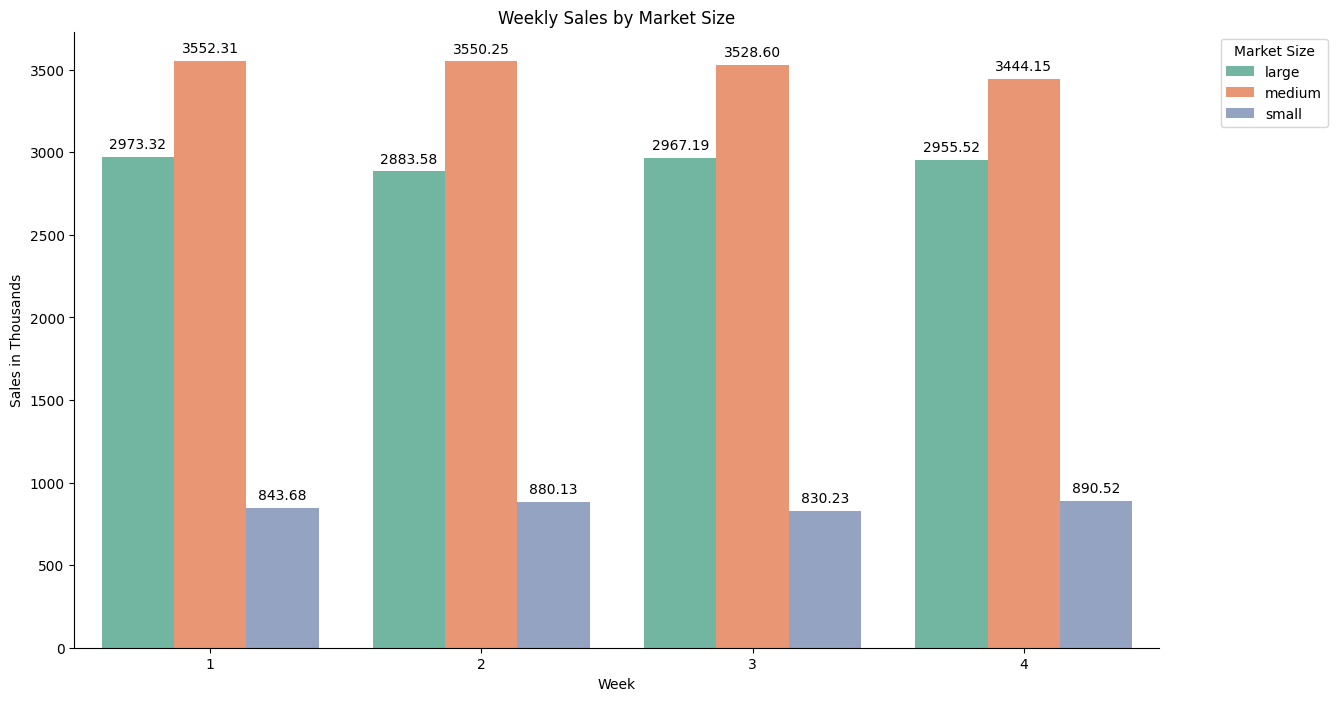

In [36]:
weekly_sales = marketing_data.groupby(['week', 'MarketSize'])['SalesInThousands'].sum().reset_index()
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='week', y='SalesInThousands', hue='MarketSize', data=weekly_sales, palette='Set2')

for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

sns.despine()
plt.title('Weekly Sales by Market Size')
plt.xlabel('Week')
plt.ylabel('Sales in Thousands')
plt.legend(title='Market Size',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

As we can see, there is no support for the idea that sales may be influenced by the week, as all 4 weeks have almost the same sales numbers.

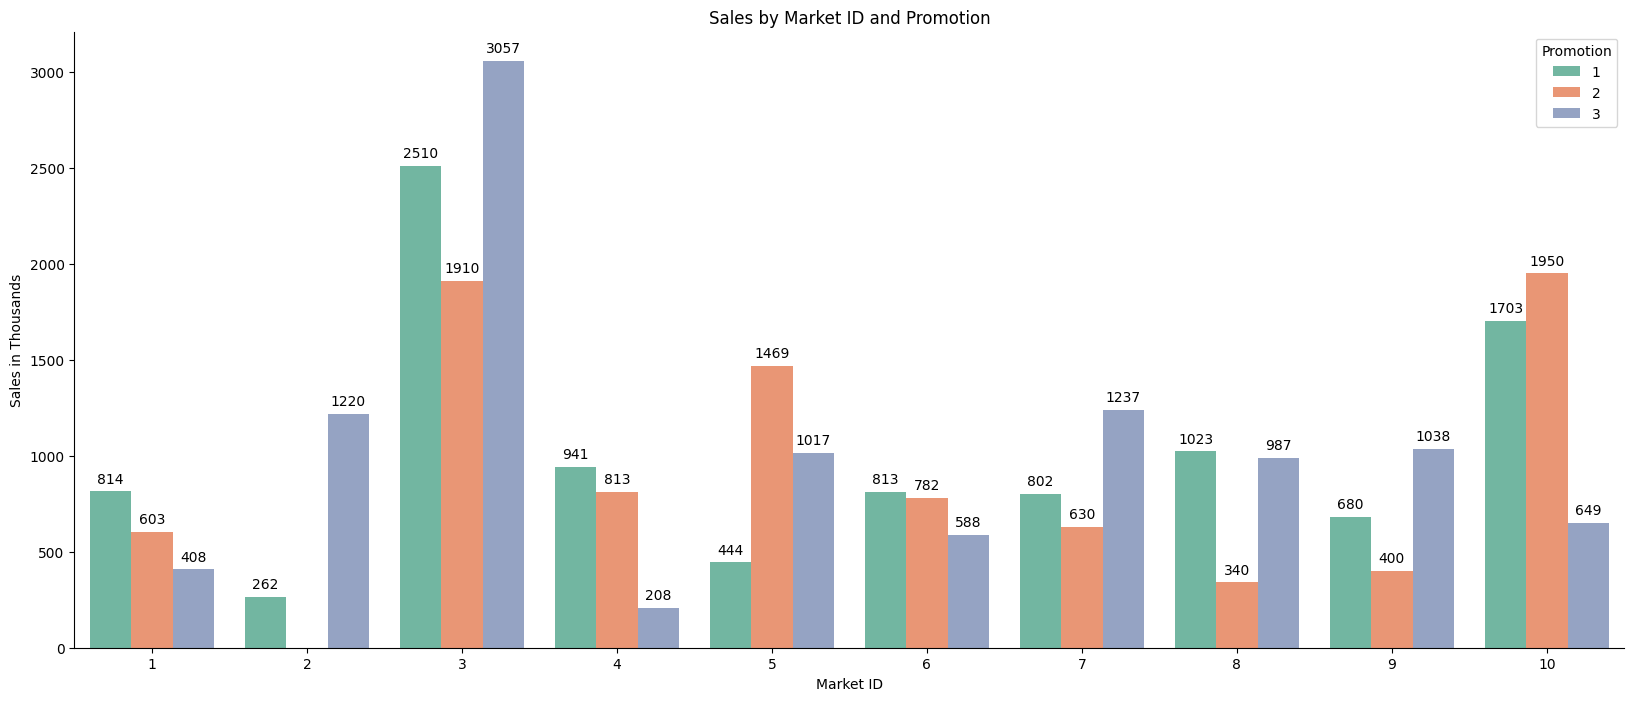

In [37]:
market_promotion_sales = marketing_data.groupby(['MarketID', 'Promotion'])['SalesInThousands'].sum().reset_index()

plt.figure(figsize=(20, 8))
barplot = sns.barplot(x='MarketID', y='SalesInThousands', hue='Promotion', data=market_promotion_sales, palette='Set2')


for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

sns.despine()
plt.title('Sales by Market ID and Promotion')
plt.xlabel('Market ID')
plt.ylabel('Sales in Thousands')
plt.legend(title='Promotion')
plt.show()

It's quite interesting to see that the second market hasn't tried promotion number 2. Additionally, it is noteworthy that Market 3 and Market 10 have such different reactions to promotions 1 and 3, even though both are considered large markets. A better definition of large, medium, and small markets would be helpful because, at this moment, for all we know, Market 3 could be many times larger than Market 10 but hold the same classification.

## <center>A\B test<center>

Null Hypothesis (H0)<br>
There is no significant difference in the mean sales among the three promotions.<br>
𝐻0:𝜇1=𝜇2=𝜇3<br>
​<br>
Alternative Hypothesis (H1)<br>
At least one promotion results in a significantly different mean sales compared to the others.<br>
𝐻1:At least one 𝜇𝑖 is different<br>

We will set alpha = 0.05


In [22]:
marketing_data.groupby('Promotion')['SalesInThousands'].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


In [23]:
sample_size = marketing_data['Promotion'].value_counts()
sample_size

Promotion
3    188
2    188
1    172
Name: count, dtype: int64

In [24]:
variant_proportion = marketing_data['Promotion'].value_counts(normalize=True)
variant_proportion

Promotion
3    0.343066
2    0.343066
1    0.313869
Name: proportion, dtype: float64

Lets perform sanity test to check if samples are random.

In [25]:
contingency_table = pd.crosstab(index=marketing_data['Promotion'], columns='count')

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:", expected)

Chi-Square Test Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies: [[172.]
 [188.]
 [188.]]


As we get p-value of 1, and chi test statistic as 0.0 it suggests that sample is perfectly random.

### <center>Analysis of variance<center>

In [26]:
promotion_1_sales = marketing_data[marketing_data['Promotion'] == 1]['SalesInThousands']
promotion_2_sales = marketing_data[marketing_data['Promotion'] == 2]['SalesInThousands']
promotion_3_sales = marketing_data[marketing_data['Promotion'] == 3]['SalesInThousands']

In [27]:
anova_result = f_oneway(promotion_1_sales, promotion_2_sales, promotion_3_sales)
f_statistic = anova_result.statistic
p_value = anova_result.pvalue

print(f"ANOVA test result: F-statistic = {f_statistic:.5f}, p-value = {p_value:.10f}")

ANOVA test result: F-statistic = 21.95349, p-value = 0.0000000007


An extremely small p-value suggests that there is a significant difference between one of the promotions. Let's conduct a pairwise t-test to look into it deeper.

In [28]:
t_stat_1_2, p_val_1_2 = ttest_ind(promotion_1_sales, promotion_2_sales)
t_stat_1_3, p_val_1_3 = ttest_ind(promotion_1_sales, promotion_3_sales)
t_stat_2_3, p_val_2_3 = ttest_ind(promotion_2_sales, promotion_3_sales)

p_vals = [p_val_1_2, p_val_1_3, p_val_2_3]
adjusted_p_vals = multitest.multipletests(p_vals, method='bonferroni')[1]

print("Pairwise t-tests with Bonferroni correction:")
print("Promotion 1 vs Promotion 2: p-value =", adjusted_p_vals[0])
print("Promotion 1 vs Promotion 3: p-value =", adjusted_p_vals[1])
print("Promotion 2 vs Promotion 3: p-value =", adjusted_p_vals[2])

Pairwise t-tests with Bonferroni correction:
Promotion 1 vs Promotion 2: p-value = 1.065200895364037e-09
Promotion 1 vs Promotion 3: p-value = 0.3623900181693983
Promotion 2 vs Promotion 3: p-value = 4.688682910883213e-06


From this, we see that there is a significant difference between the mean sales of Promotion 1 and Promotion 2, with Promotion 1 having a higher mean. The same situation exists between Promotion 3 and Promotion 2, with Promotion 3 having a higher mean. Promotion 1 and Promotion 3 are not significantly different. So far, we have indications suggesting that Promotion 2 is the least successful.

### <center>Treatment effect<center>

In [29]:
mean_sales_1 = np.mean(promotion_1_sales)
mean_sales_2 = np.mean(promotion_2_sales)
mean_sales_3 = np.mean(promotion_3_sales)

effect_1_vs_2 = mean_sales_1 - mean_sales_2
effect_1_vs_3 = mean_sales_1 - mean_sales_3
effect_2_vs_3 = mean_sales_2 - mean_sales_3

print("Treatment Effect (Promotion 1 vs Promotion 2):", effect_1_vs_2)
print("Treatment Effect (Promotion 1 vs Promotion 3):", effect_1_vs_3)
print("Treatment Effect (Promotion 2 vs Promotion 3):", effect_2_vs_3)

Treatment Effect (Promotion 1 vs Promotion 2): 10.76959673428997
Treatment Effect (Promotion 1 vs Promotion 3): 2.734543542800594
Treatment Effect (Promotion 2 vs Promotion 3): -8.035053191489375


### <center>Confidance intervals<center>

In [30]:
ci_1 = hp.bootstrap(promotion_1_sales)
ci_2 = hp.bootstrap(promotion_2_sales)
ci_3 = hp.bootstrap(promotion_3_sales)

- **Non-overlapping Intervals**: The confidence intervals for Promotion 1 and Promotion 2 do not overlap, suggesting a significant difference in their mean sales.
- **Overlapping Intervals**: The confidence intervals for Promotion 1 and Promotion 3 overlap, indicating that the difference in their mean sales might not be statistically significant.


In [31]:
ci_1_analytical_z = hp.analytical_ci_z(promotion_1_sales)
ci_2_analytical_z = hp.analytical_ci_z(promotion_2_sales)
ci_3_analytical_z = hp.analytical_ci_z(promotion_3_sales)

In [32]:
print("Bootstrap 95% CI for Promotion 1 Sales:                  ", ci_1)
print("Analytical 95% CI for Promotion 1 Sales (z-distribution):", ci_1_analytical_z)
print("Bootstrap 95% CI for Promotion 2 Sales:                  ", ci_2)
print("Analytical 95% CI for Promotion 2 Sales (z-distribution):", ci_2_analytical_z)
print("Bootstrap 95% CI for Promotion 3 Sales:                  ", ci_3)
print("Analytical 95% CI for Promotion 3 Sales (z-distribution):", ci_3_analytical_z)

Bootstrap 95% CI for Promotion 1 Sales:                   (55.658927325581395, 60.66372674418604)
Analytical 95% CI for Promotion 1 Sales (z-distribution): (55.62511760549629, 60.57290565031767)
Bootstrap 95% CI for Promotion 2 Sales:                   (45.22840159574467, 49.51182579787235)
Analytical 95% CI for Promotion 2 Sales (z-distribution): (45.16966437055063, 49.4891654166834)
Bootstrap 95% CI for Promotion 3 Sales:                   (53.05657180851065, 57.78871808510638)
Analytical 95% CI for Promotion 3 Sales (z-distribution): (52.967818137801615, 57.76111803241116)


After getting calculating results, we can see that confidance intervals are extremely similar.

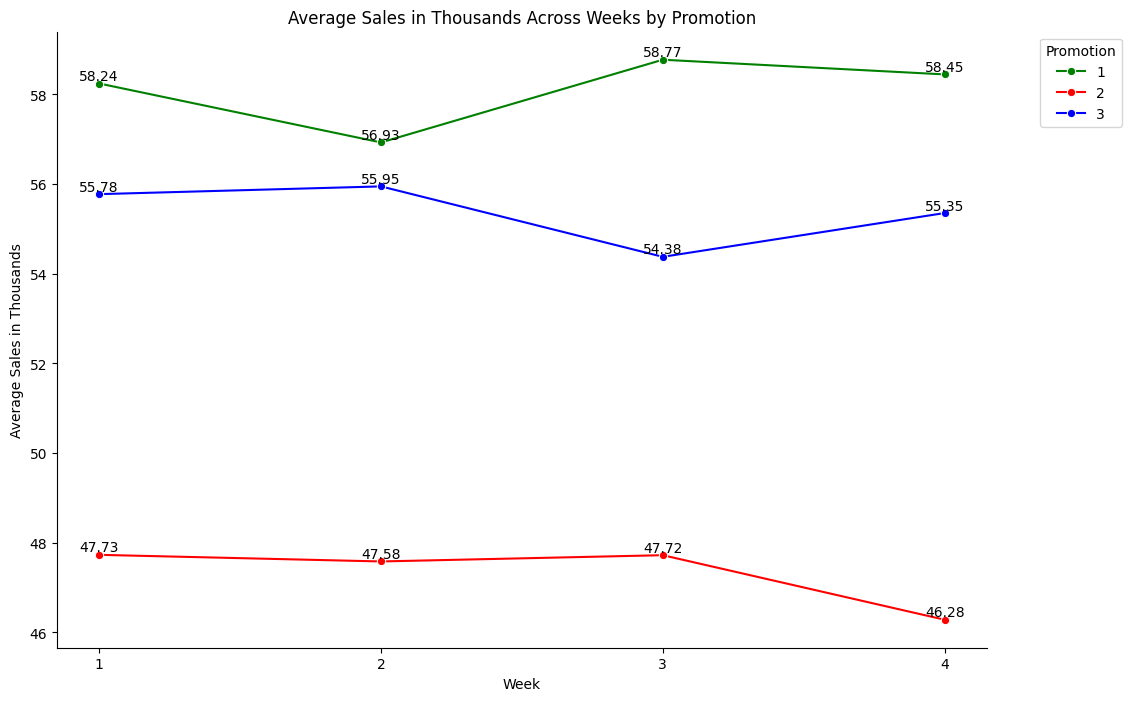

In [33]:
weekly_sales = marketing_data.groupby(['week', 'Promotion'])['SalesInThousands'].mean().reset_index()
plt.figure(figsize=(12, 8))
custom_palette = {1: "green", 2: "red", 3: "blue"}
sns.lineplot(data=weekly_sales, x='week', y='SalesInThousands', hue='Promotion',palette=custom_palette, marker='o')
for index, row in weekly_sales.iterrows():
    plt.text(row['week'], row['SalesInThousands'], f"{row['SalesInThousands']:.2f}", ha='center', va='bottom', fontsize=10)

sns.despine()
plt.title('Average Sales in Thousands Across Weeks by Promotion')
plt.xlabel('Week')
plt.ylabel('Average Sales in Thousands')
plt.legend(title='Promotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(weekly_sales['week'].unique())
plt.grid(False)

plt.show()

As we going to use this graph in dashboard, lets save our weekly data to csv file

## <center> Conclusion <center>

Based on the treatment effects, confidence intervals, and p-values, the recommendation is to focus on Promotions 1 and 3, as they are both more effective than Promotion 2 in terms of mean sales. There is no significant difference between Promotions 1 and 3, suggesting they are similarly effective. However, if we had to choose one without further investigation, Promotion 1 should be picked based on its treatment effect.